In [1]:
import h5py
import numpy as np
import torch
import torch.utils.data
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
class ModulationDataSets(Dataset):
    def __init__(self, file):
        self.h5 = h5py.File(file, "r")
        self.label_id = self.h5['sampleType']
        _, self.length = self.label_id.shape
        self.img = self.h5['sampleData']
        self.toTensor = ToTensor()

    def __getitem__(self, idx):
        return self.toTensor(self.img[:, :, idx]).float(), torch.tensor(int(self.label_id[0, idx] - 1),
                                                                        dtype=torch.long), torch.tensor(
            int(self.label_id[1, idx]), dtype=torch.long)

    def __len__(self):
        return self.length

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.h5.close()

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
    nn.Conv2d(10, 20, kernel_size=5), nn.Dropout2d(0.2), nn.MaxPool2d(2), nn.ReLU(),
    nn.Flatten(),
    nn.Linear(11700, 4096), nn.ReLU(),
    nn.Linear(4096, 50), nn.ReLU(),
    nn.Dropout(0),
    nn.Linear(50, 8),
    nn.Softmax()
)
net.load_state_dict(torch.load("basic-8.parm"))
net.eval()

Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (4): Dropout2d(p=0.2, inplace=False)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=11700, out_features=4096, bias=True)
  (9): ReLU()
  (10): Linear(in_features=4096, out_features=50, bias=True)
  (11): ReLU()
  (12): Dropout(p=0, inplace=False)
  (13): Linear(in_features=50, out_features=8, bias=True)
  (14): Softmax(dim=None)
)

In [4]:
X = torch.rand(size=(1, 1, 195, 64), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([1, 10, 191, 60])
MaxPool2d output shape: 	 torch.Size([1, 10, 95, 30])
ReLU output shape: 	 torch.Size([1, 10, 95, 30])
Conv2d output shape: 	 torch.Size([1, 20, 91, 26])
Dropout2d output shape: 	 torch.Size([1, 20, 91, 26])
MaxPool2d output shape: 	 torch.Size([1, 20, 45, 13])
ReLU output shape: 	 torch.Size([1, 20, 45, 13])
Flatten output shape: 	 torch.Size([1, 11700])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 50])
ReLU output shape: 	 torch.Size([1, 50])
Dropout output shape: 	 torch.Size([1, 50])
Linear output shape: 	 torch.Size([1, 8])
Softmax output shape: 	 torch.Size([1, 8])


C:\Users\ZGYwi\AppData\Local\Temp\ipykernel_13120\2052838066.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = layer(X)


In [7]:
train_path = r'E:\test.h5'
test_path = r'E:\train.h5'
train_dataset = ModulationDataSets(train_path)
test_dataset = ModulationDataSets(test_path)
batch_size = 100
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size,
    shuffle=False, num_workers=0, drop_last=False)

## 提取单独类型

In [69]:
name = ['singlefreq', 'freqdiv', 'LFM', 'QFM', '2FSK', '4FSK', 'BPSK', 'QPSK']
path = r"E:\test-large.h5"
h5 = h5py.File(path)
g_label = h5['sampleType'][:]
g_data = h5['sampleData'][:, :, :]
h5.close()
toTensor = ToTensor()

In [6]:
def filter(type=None, snr=None) -> np.ndarray:
    full = (g_label[0, :] != None)
    if (type != None):
        full = full & (g_label[0, :] == type)
    if (snr != None):
        full = full & (g_label[1, :] == snr)
    # 将TrueFalse数组转换为索引
    ids = np.argwhere(full).reshape(-1)
    return ids


def getData(type, snr):
    ids = filter(type, snr).tolist()
    length = len(ids)
    return g_data[:, :, ids], g_label[0, ids].reshape(1, -1)


class TypeSet(Dataset):
    def __init__(self, type, snr):
        self.img, self.label = getData(type, snr)
        _, self.length = self.label.shape

    def __getitem__(self, idx):
        return toTensor(self.img[:, :, idx]).float(), torch.tensor(self.label[0, idx] - 1, dtype=torch.int)

    def __len__(self):
        return self.length


def getLoader(type, snr):
    set = TypeSet(type, snr)
    #print(set.__len__())
    return torch.utils.data.DataLoader(
        dataset=set, batch_size=set.__len__(), shuffle=False,
        num_workers=0, drop_last=False)


x = getLoader(1, -10)

In [ ]:
x, y = getData(1, -10)
x.shape, y.shape

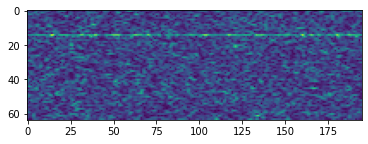

In [67]:
x1=x[:,:,1]
plt.imshow(x1.transpose())

In [68]:
x1.resize(1,1,195,64)
xa=torch.tensor(x1,dtype=torch.float)
y_hat=net(xa)
pred=y_hat.data.max(1,keepdim=True)[1]
print(name[pred])

singlepulse


In [11]:
result = np.ndarray((8, 41))
for n in range(1, 1 + len(name)):
    for snr in range(-10, 31):
        img, labels = next(iter(getLoader(n, snr)))
        length = len(labels)
        output = net(img)
        pred = output.data.max(1, keepdim=True)[1].reshape(length)
        pred = pred.numpy()
        labels = labels.reshape(length).numpy()
        err_idx = np.argwhere(pred != labels)
        accuacy=(length - len(err_idx)) * 100 / length
        print("{}:\t {}dB\t accuracy:{}%".format(name[n - 1], snr, (length - len(err_idx)) * 100 / length))
        result[n-1,snr+10]=accuacy
        #SNR_array.append(snr.tolist()[0])
        #accuracy_array.append(80 - 80 * len(err_idx) / 80)

C:\Users\ZGYwi\AppData\Local\Temp\ipykernel_16364\971741046.py:24: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return toTensor(self.img[:, :, idx]).float(), torch.tensor(self.label[0, idx] - 1, dtype=torch.int)
R:\App\miniconda\envs\torch-cuda\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


singlepulse:	 -10dB	 accuracy:58.53658536585366%
singlepulse:	 -9dB	 accuracy:66.94915254237289%
singlepulse:	 -8dB	 accuracy:69.62962962962963%
singlepulse:	 -7dB	 accuracy:81.02189781021897%
singlepulse:	 -6dB	 accuracy:86.71875%
singlepulse:	 -5dB	 accuracy:90.8256880733945%
singlepulse:	 -4dB	 accuracy:89.76377952755905%
singlepulse:	 -3dB	 accuracy:97.0873786407767%
singlepulse:	 -2dB	 accuracy:97.52066115702479%
singlepulse:	 -1dB	 accuracy:98.2905982905983%
singlepulse:	 0dB	 accuracy:97.95918367346938%
singlepulse:	 1dB	 accuracy:97.01492537313433%
singlepulse:	 2dB	 accuracy:99.00990099009901%
singlepulse:	 3dB	 accuracy:99.18032786885246%
singlepulse:	 4dB	 accuracy:98.2905982905983%
singlepulse:	 5dB	 accuracy:100.0%
singlepulse:	 6dB	 accuracy:100.0%
singlepulse:	 7dB	 accuracy:100.0%
singlepulse:	 8dB	 accuracy:100.0%
singlepulse:	 9dB	 accuracy:100.0%
singlepulse:	 10dB	 accuracy:100.0%
singlepulse:	 11dB	 accuracy:100.0%
singlepulse:	 12dB	 accuracy:100.0%
singlepulse:	 

In [65]:
result

array([[ 51.92307692,  63.02521008,  60.15625   ,  75.47169811,
         81.14754098,  84.09090909,  86.33093525,  90.35087719,
         92.68292683,  96.49122807,  99.21875   , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        , 100.        , 100.        , 100.        ,
        100.        ],
       [ 92.66055046,  95.76271186,  94.85294118,  94.7826087 ,
         97.87234043,  99.25373134,  96.26168224,  99.20634921,
        100.        ,  96.15384615,  99.19354839,  95.79831933,
         98.31932773,  98.36065574,  97.87234043,  99.04761905,
         99.21259843,  96.875     ,  99.11504425,  98.50746269,
         95.68965

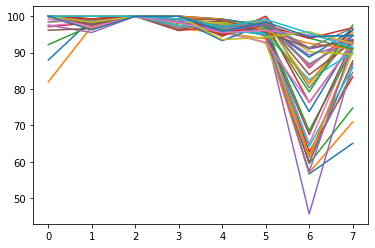

In [57]:
plt.plot(result)

In [17]:
import matplotlib.pyplot as plt

accuacy = []
for img, labels in test_loader:
    #plt.imshow(img[i, 0, :, :].t(), cmap="gray")
    #plt.title('predict:{} real:{}'.format(name[pred[i]], name[labels[i]]))
    #plt.show()
    print('predict:{} real:{}'.format(pred, labels))
    err_idx = np.argwhere(pred != labels)
    accuacy.append(100 - len(err_idx))
plt.plot(accuacy)

NameError: name 'test_loader' is not defined

## 单SNR测试

In [7]:
path = r"E:\test1.h5"
file = h5py.File(path, "r")
file.keys()

<KeysViewHDF5 ['SNRData', 'SNRType']>

In [35]:
file['SNRType']

<HDF5 dataset "SNRType": shape (5, 3280), type "<f8">

In [8]:
file.close()

In [5]:
class SNRDataSets(Dataset):
    def __init__(self, file):
        self.h5 = h5py.File(file, "r")
        self.label_id = self.h5['SNRType']
        _, self.length = self.label_id.shape
        self.img = self.h5['SNRData']
        self.toTensor = ToTensor()

    def __getitem__(self, idx):
        return (self.toTensor(self.img[:, :, idx]).float(),
                torch.tensor(int(self.label_id[0, idx] - 1), dtype=torch.long),
                torch.tensor(self.label_id[1, idx]))

    def __len__(self):
        return self.length

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.h5.close()

In [9]:
snr_dataset = SNRDataSets(path)
snr_loader = torch.utils.data.DataLoader(
    dataset=snr_dataset, batch_size=80,
    shuffle=False, num_workers=0, drop_last=False)

In [45]:
img, label, snr = next(iter(snr_loader))

In [46]:
img.shape

torch.Size([80, 1, 196, 64])

In [47]:
label.shape

torch.Size([80])

In [10]:
SNR_array = []
accuracy_array = []
for img, labels, snr in snr_loader:
    length = len(labels)
    output = net(img)
    pred = output.data.max(1, keepdim=True)[1].reshape(length)
    pred = pred.numpy()
    labels = labels.reshape(length).numpy()
    err_idx = np.argwhere(pred != labels)
    # print("SNR:{} accuracy:{}%".format(snr[0],80-80*len(err_idx)/80))
    SNR_array.append(snr.tolist()[0])
    accuracy_array.append((length - len(err_idx)) / length * 100)

E:\App\Miniconda3\envs\torch-cuda\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0, 0.5, 'accuracy')

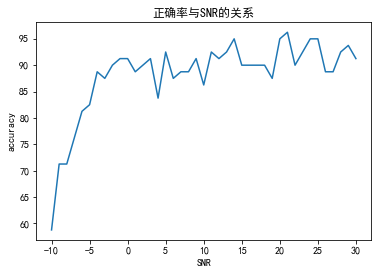

In [12]:
plt.plot(SNR_array, accuracy_array)
plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

plt.title("正确率与SNR的关系")
plt.xlabel("SNR")
plt.ylabel("accuracy")